### Load Libraries

In [109]:
import pandas as pd
import numpy as np
import prophet
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
print("All libraries imported successfully!")

All libraries imported successfully!


### Get Data from EDGAR using edgartool package

In [40]:
ticker = yf.Ticker("AAPL")
financials = ticker.quarterly_financials.T  # Get quarterly data
financials.to_csv("apple_quarterly_financials.csv")
print(financials.head())

            Tax Effect Of Unusual Items  Tax Rate For Calcs  \
2025-06-30                          0.0            0.163997   
2025-03-31                          0.0            0.155000   
2024-12-31                          0.0            0.147000   
2024-09-30                          0.0            0.210000   
2024-06-30                          0.0            0.159000   

            Normalized EBITDA  \
2025-06-30       3.103200e+10   
2025-03-31       3.225000e+10   
2024-12-31       4.591200e+10   
2024-09-30       3.250200e+10   
2024-06-30       2.820200e+10   

            Net Income From Continuing Operation Net Minority Interest  \
2025-06-30                                       2.343400e+10            
2025-03-31                                       2.478000e+10            
2024-12-31                                       3.633000e+10            
2024-09-30                                       1.473600e+10            
2024-06-30                                       2.1

### Cleaning and modiling Data

In [92]:
df = pd.read_csv("apple_quarterly_financials.csv")
df = df.rename(columns={'Unnamed: 0' : 'Date'})  # Renaming the unnames : 0 TO Date
df['Date'] = pd.to_datetime(df['Date']) # Converting Date column to datetime

# Keep only Data [Date , Revenue , Expensexs]
df = df[['Date', 'Total Revenue', 'Operating Expense']]	

#Simplyfing columns names 
df.columns = ['Date' , 'Revenue' , 'Expenses']

# Converting to Millions for readability
df['Revenue'] = df['Revenue'] / 1000000
df['Expenses'] = df['Expenses'] / 1000000

# Checking Missing value in dataset
print("Missing Value :\n" ,df.isnull().sum())

# Filling missing value with privious value if null exists
#df.fillna(method='ffill' , inplace=True)

# Rewmoving negative Values
df = df[df['Revenue'] > 0]
df = df[df['Expenses'] > 0]

#Sorting by date
df = df.sort_values('Date')

df.to_csv("cleaned_financials.csv", index=False)
print("Cleaned data:\n", df.head())

Missing Value :
 Date        0
Revenue     0
Expenses    0
dtype: int64
Cleaned data:
         Date   Revenue  Expenses
4 2024-06-30   85777.0   14326.0
3 2024-09-30   94930.0   14288.0
2 2024-12-31  124300.0   15443.0
1 2025-03-31   95359.0   15278.0
0 2025-06-30   94036.0   15516.0


### Plotting revenue and expenses

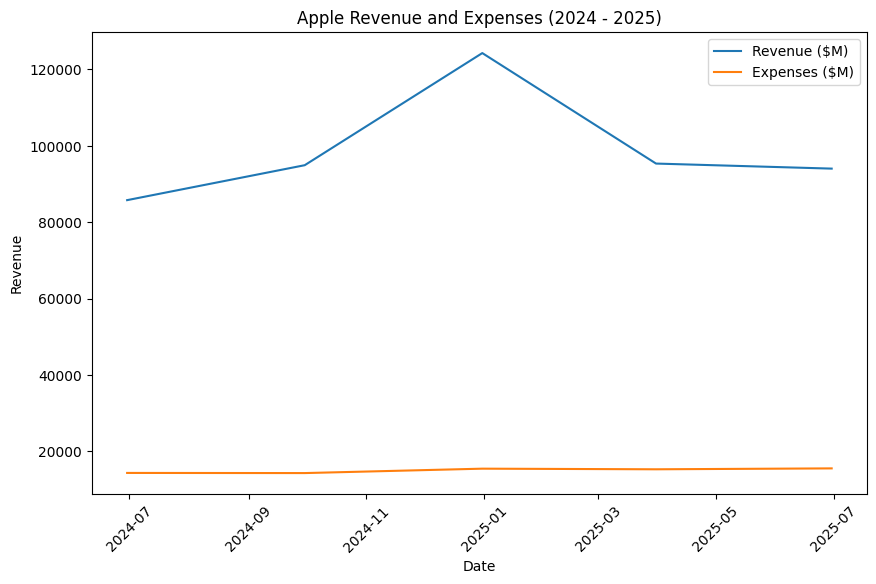

In [110]:
df = pd.read_csv("cleaned_financials.csv")
df['Date'] = pd.to_datetime(df['Date'])
 

plt.figure(figsize=(10, 6))
sns.lineplot(data = df , x ='Date' , y='Revenue' , label = 'Revenue ($M)')
sns.lineplot(data = df , x='Date'  , y='Expenses' , label='Expenses ($M)')
plt.title("Apple Revenue and Expenses (2024 - 2025)")
plt.xticks(rotation=45)
plt.savefig("Visuals/apple_revenue_expenses.png")
plt.show()

### Plotting revenue by quarter

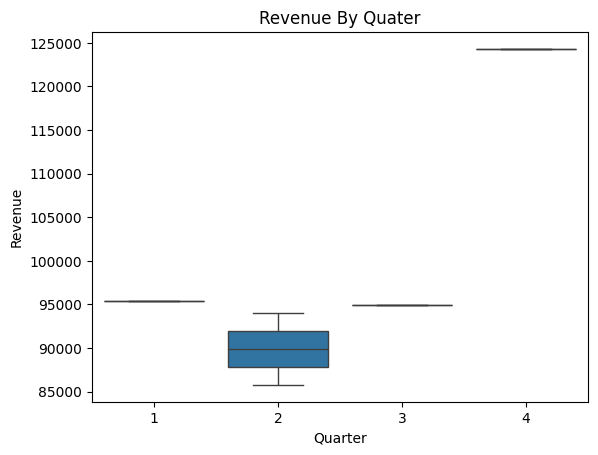

In [106]:
df['Quarter'] = df['Date'].dt.quarter
sns.boxplot(x='Quarter' , y='Revenue' , data=df)
plt.title("Revenue By Quater")
plt.savefig("Visuals/revenue_by_quarter.png")
plt.show()

### Forecast with Prophet
#### What to Do: Predict revenue and expenses for the next 8 quarters (2 years) using Prophet.
#### Why: Forecasting shows you can predict future trends, a must for The Algebra Group company.

In [118]:
# Prepare data for Prophet
revenue_df = df[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})

# Train model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(revenue_df)

# Forcating for 2years
future = model.make_future_dataframe(periods=8 , freq = 'Q')
forecast = model.predict(future)

# Save Forcast in csv
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_revenue.csv")


16:46:16 - cmdstanpy - INFO - Chain [1] start processing
16:46:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Tahseen Ashrafi\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


### Plot Forcast

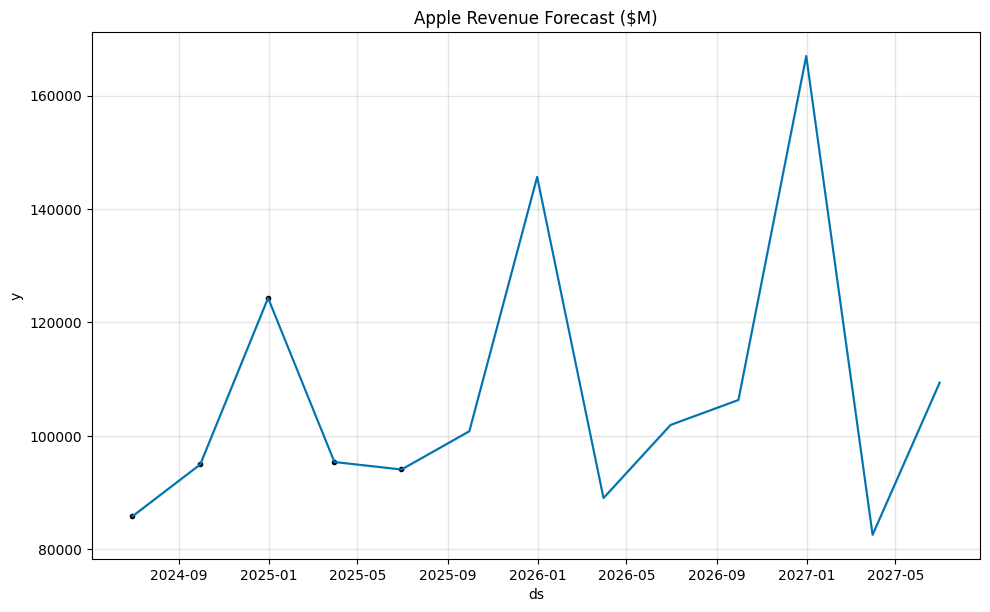

In [120]:
model.plot(forecast)
plt.title("Apple Revenue Forecast ($M)")
plt.savefig("Visuals/revenue_forecast.png")
plt.show()